In [1]:
from sklearn.linear_model import LinearRegression  # 선형회귀
from sklearn.preprocessing import PolynomialFeatures # 다항특성을 만들어주는 라이브러리
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 표시 해결
# 한글설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # windows 사용자
# matplotlib.rcParams['font.family'] = 'AppleGothic Gothic' # Mac사용자
matplotlib.rcParams['font.size'] = '10' # 글자크기

In [2]:
# 타이타닉의 생존자 분류 모델을 구현하시오.
# target : survived
# data : 그외

# data로 사용할 feature
# pclass: 승객등급
# survived : 생존1/죽음0
# sibsp: 함께 탑승한 형제 또는 배우자 수
# parch : 함께 탑승한 부모 또는 자녀 수
# ticket : 티켓 번호
# cabin : 선실번호  # null값이 너무 많아서 삭제
# embarked : 탑승 장소

# 분류 : 로지스틱,랜덤포레스트, 결정트리

In [3]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')
df_train.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0,NaN,S,NaN,"Cornwall / Akron, OH"


In [4]:
df_train.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,916.000000,916.000000,741.000000,916.000000,916.000000,916.000000,85.000000
mean,2.292576,0.385371,30.231444,0.532751,0.371179,32.532050,157.870588
std,0.842576,0.486949,13.934240,1.125957,0.837508,47.416524,98.257653
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,68.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,148.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,249.000000
max,3.000000,1.000000,74.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
# 삭제해야하는 컬럼
# name, ticket, cabin, body, home.dest 5개
df_train = df_train.drop(['name','ticket','cabin','body','home.dest'],axis=1)
df_train

df_test = df_test.drop(['name','ticket','cabin','body','home.dest'],axis=1)
df_test

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,3,0,male,38.0,0,0,7.8958,S
1,2,1,female,21.0,0,1,21.0000,S
2,2,0,male,42.0,1,0,27.0000,S
3,3,0,male,NaN,0,0,14.5000,S
4,2,0,male,25.0,0,0,31.5000,S
...,...,...,...,...,...,...,...,...
388,3,0,male,33.0,0,0,7.8542,S
389,2,1,female,31.0,0,0,21.0000,S
390,3,1,male,NaN,0,0,7.7500,Q
391,3,0,male,NaN,0,0,7.7500,Q


In [6]:
# 생존 : 1, 사망 : 0
df_train['survived'].value_counts()

survived
0    563
1    353
Name: count, dtype: int64

<Axes: xlabel='survived'>

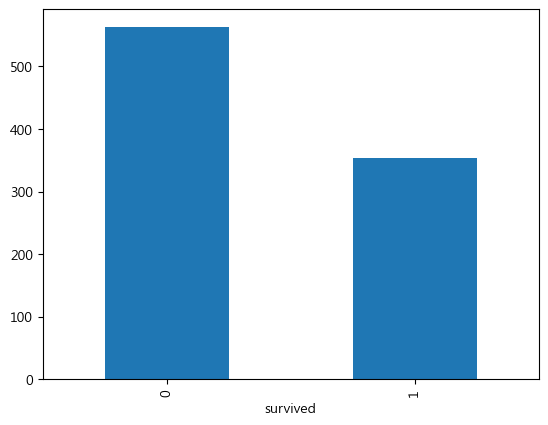

In [7]:
# bar
df_train['survived'].value_counts().plot.bar()

feature간 관련성 부분을 확인

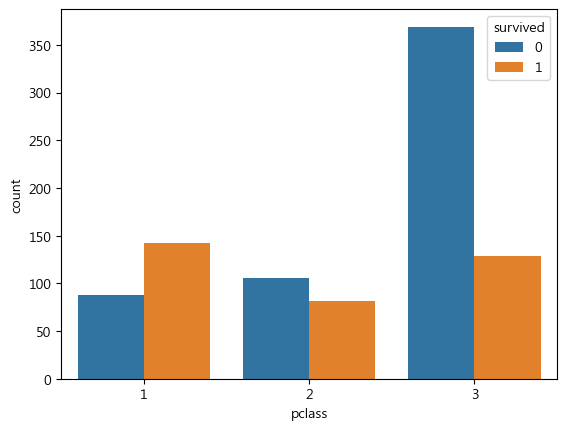

In [8]:
# 생존과 pclass 간의 관계
# pclass : Passenger Class. 승객 등급
df_train['pclass'].value_counts()

import seaborn as sns
# sns.countplot 으로 승객 등급별 생존여부를 그려보시오
# x축은 pclass, y축은 생존여부
# hue: y축 values
ax = sns.countplot(x='pclass',hue='survived',data=df_train)

In [9]:
# 생존자의 pclass 별 인원
df_train[df_train['survived']==1]['pclass'].value_counts()

# 승객 등급이 낮을 수록 생존한 승객이 적음 -> 사망확률이 높다

pclass
1    142
3    129
2     82
Name: count, dtype: int64

In [10]:
df_train[df_train['survived']==0]['pclass'].value_counts()

pclass
3    369
2    106
1     88
Name: count, dtype: int64

##### T-test
: 두 집단 내 변화량을 고려하여 두 집단 간 평균이 통계적으로 유의미한 차이를 가지는 지 검증 

예)\
성별에 따른 시험 평균점수 차이를 독립표본 T검정을 통해 통계적으로 유의미한지 확인하려고 한다

In [11]:
# T-test
from scipy import stats

# 함수 생성 - 데이터,컬럼이름
def valid_features(df,col_name):  # df_train[df_train['age']>0],age-741, age
    
    # 그래프 출력
    g = sns.FacetGrid(df,col='survived')   # agr 컬럼의 데이터로 분류해서 생존도 그래프 출력
    g.map(plt.hist,col_name,bins=30)
    # 히스토그램 그래프 출력 -  x축이 age, y축은 생존자 명
    
    
    # 생존자데이터
    titanic_survived = df[df['survived']==1]  # 생존자 데이터 306
    titanic_survived_static = np.array(titanic_survived[col_name]) # 생존자데이터 내의 컬럼
    # 표준편차
    print('data 생존자 std : ','%.2f'%np.std(titanic_survived_static)) # 생존자데이터의 표준편차 출력
    
    # 사망자 데이터
    titanic_dead = df[df['survived']==0]  # 사망자 데이터 435
    titanic_dead_static = np.array(titanic_dead[col_name]) # 사망자데이터 내의 컬럼
    # 표준편차
    print('data 사망자 std : ','%.2f' % np.std(titanic_dead_static)) # 사망자데이터의 표준편차 출력
    
    #---------------------------
    # T-test로 두 집단의 평균 차이를 검정
    # T-test 0.05보다 작거나 큰 것을 가지고 판단
    tTestResult = stats.ttest_ind(titanic_survived[col_name],titanic_dead[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name],titanic_dead[col_name],equal_var=False)
    print('p-value assuming equal : %.3f and %.3f' % tTestResult)
    print('p-value not assuming equal :  %.3f and %.3f' % tTestResultDiffVar)
    

data 생존자 std :  14.22
data 사망자 std :  13.71
p-value assuming equal : -0.546 and 0.585
p-value not assuming equal :  -0.543 and 0.587


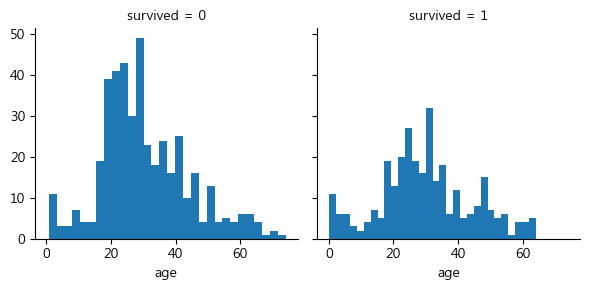

In [12]:
# 나이와 생존의 두 집단의 관계 검정

# df_train[df_train['age']>0] - age값이 들어있는 전체데이터, age컬럼명
# p-value 값이 0.05 보다 크므로, 귀무가설 채택(두 집단 간 유의미한 차이가 없다) -> 관련성이 없다.
valid_features(df_train[df_train['age']>0],'age')

data 생존자 std :  0.64
data 사망자 std :  1.34
p-value assuming equal : -2.118 and 0.034
p-value not assuming equal :  -2.446 and 0.015


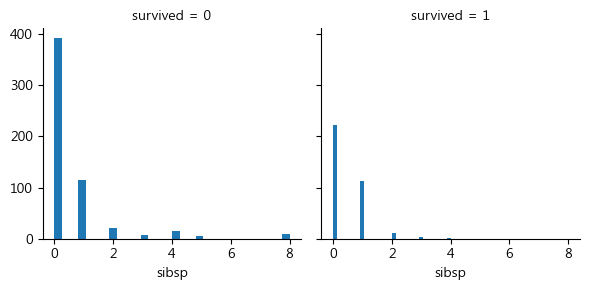

In [13]:
# sibsp feature : 함께 탑승한 형제/배우자 수

valid_features(df_train,'sibsp')

# p-value값이 0.05보다 작게 나옴
#  -> 혼자 탑승한 승객 수가 많았고, 형제/배우자와 함께 탑승한 경우 생존확률이 높았다
# -> 귀무가설 기각 : sibsp와 survived 집단 간 유의미한 차이가 있다 -> 관련성이 있다.


데이터 확인

In [14]:
# 성별 확인
df_train['sex'].value_counts()

sex
male      581
female    335
Name: count, dtype: int64

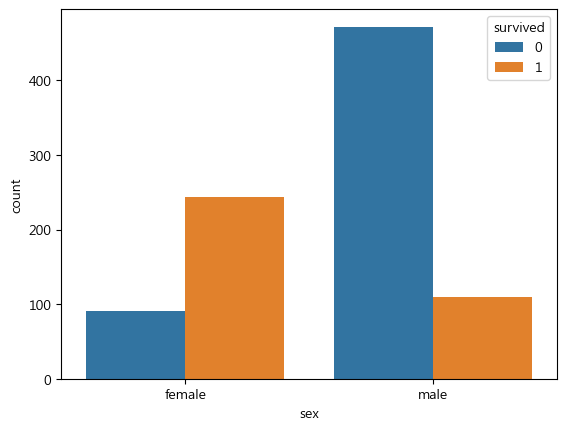

In [15]:
# 두 feature 간의 그래프 countplot
ax = sns.countplot(x='sex',hue='survived',data=df_train)

# 성별에 따른 탑승객 수는 남자 > 여자
# 남성이 더 많은 비율로 사망했음을 알 수 있다

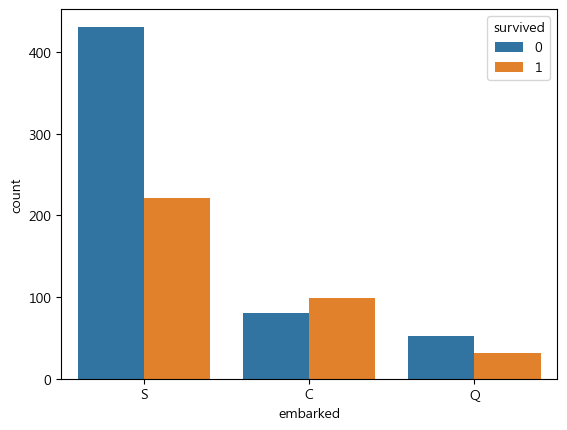

In [16]:
# embarked : 3개의 승선항(탑승위치)
df_train['embarked'].value_counts()

ax = sns.countplot(x='embarked',hue='survived',data=df_train)

In [17]:
df_train.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

data 생존자 std :  0.74
data 사망자 std :  0.89
p-value assuming equal : 1.865 and 0.063
p-value not assuming equal :  1.942 and 0.052


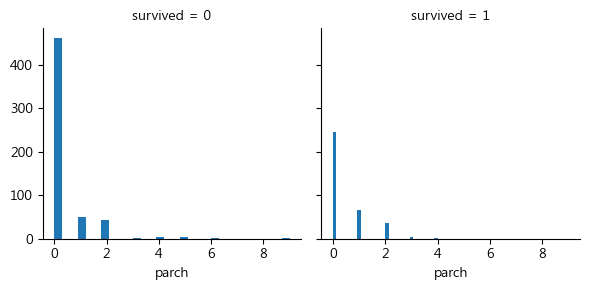

In [18]:
# parch : 함께 탑승한 부모/자녀 수
valid_features(df_train,'parch')

data 생존자 std :  60.68
data 사망자 std :  33.65
p-value assuming equal : 7.523 and 0.000
p-value not assuming equal :  6.657 and 0.000


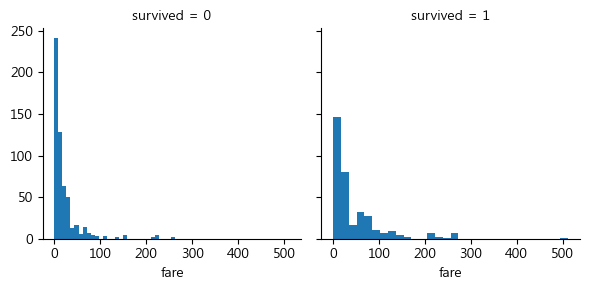

In [19]:
# fare : 승객 지불 요금
valid_features(df_train,'fare')

# 승객이 지불한 요금이 많았을수록 생존율은 높았다

In [20]:
# 데이터 전처리 (object -> int/float로..) & 결측치
# age => 데이터의 평균값으로 nan 데이터 처리
# df_train['embarked'].value_counts()

replace_mean = df_train[df_train['age']>0]['age'].mean()


# 결측치에 넣을 평균값 - train,test set 모두 적용
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embarked : 결측값  - 데이터 2개
# 데이터 중 가장 많이 나온 결과의 값을 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)


In [21]:
# df_train['embarked'].value_counts().index[0]
# df_train['embarked'].value_counts().values[0]
# df_train['embarked'].value_counts()

In [22]:
# train과 test 세트를 하나로 묶어보려고 한다 -> 한 번에 원핫인코딩 진행하려고
whole_df = pd.concat([df_train,df_test])
whole_df   # 총 1309개의 데이터

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,2,1,female,13.000000,0,1,19.5000,S
1,2,1,female,4.000000,1,1,23.0000,S
2,2,1,female,30.000000,1,0,13.8583,C
3,3,0,male,30.231444,0,0,7.7250,Q
4,3,1,female,22.000000,0,0,7.7250,Q
...,...,...,...,...,...,...,...,...
388,3,0,male,33.000000,0,0,7.8542,S
389,2,1,female,31.000000,0,0,21.0000,S
390,3,1,male,30.231444,0,0,7.7500,Q
391,3,0,male,30.231444,0,0,7.7500,Q


In [29]:
# 원핫 인코딩 후 train,test세트 분리

train_index_num = len(df_train)
train_index_num

# 원핫인코딩
whole_df_encode = pd.get_dummies(whole_df)
whole_df_encode.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,True,False,False,False,True
1,2,1,4.000000,1,1,23.0000,True,False,False,False,True
2,2,1,30.000000,1,0,13.8583,True,False,True,False,False
3,3,0,30.231444,0,0,7.7250,False,True,False,True,False
4,3,1,22.000000,0,0,7.7250,True,False,False,True,False


In [39]:
# train,test 세트 분리
# whole_df_encode.loc[:,whole_df_encode.columns != 'survived']
datas = whole_df_encode.drop({'survived'},axis=1)
target = whole_df_encode['survived']

# train : 916
train_input = datas.iloc[:train_index_num]
train_target = target.iloc[:train_index_num]

# test : 393
test_input = datas.iloc[train_index_num:]
test_target = target.iloc[train_index_num:]

머신러닝

In [42]:
# 규제 조정을 위해서 표준화 작업
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [47]:
from sklearn.linear_model import LogisticRegression

# 데이터 훈련시키기
# 로지스틱 회귀
lr = LogisticRegression(random_state=42)
lr.fit(train_input,train_target)

print(lr.score(train_input,train_target))
print(lr.score(test_input,test_target))


0.787117903930131
0.7964376590330788


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
predict = lr.predict(test_input)

confusion_matrix\
True Positive : 맞은걸 맞다고 (2사분면)\
False Positive : 틀린걸 틀렸다고(3사분면)\
True Negative : 맞은걸 틀렸다고(4사분면)\
False Negative : 틀린걸 맞았다고(1사분면)

In [68]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=test_target,y_pred=predict)
# 예측한 값과 실제 값 간의 비교

In [69]:
confmat
# TP  FN
# FP  TN

array([[214,  32],
       [ 48,  99]], dtype=int64)

In [52]:
# 경사하강법
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log_loss',max_iter=10,random_state=42)
sc.fit(train_scaled,train_target)


c:\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=10, random_state=42)

In [53]:
print(sc.score(train_scaled,train_target))
print(sc.score(test_scaled,test_target))

0.7827510917030568
0.7964376590330788


In [55]:
classes = np.unique(train_target)
classes

array([0, 1], dtype=int64)

In [56]:
train_score = []
test_score = []
for _ in range(0,300):
    sc.partial_fit(train_scaled,train_target,classes=classes)
    train_score.append(sc.score(train_scaled,train_target))
    test_score.append(sc.score(test_scaled,test_target))
    

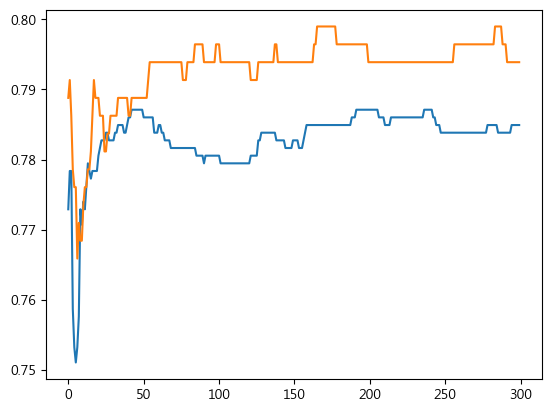

In [57]:
plt.plot(train_score)
plt.plot(test_score)

In [61]:
# 검증 세트 - cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
score = cross_validate(lr,train_scaled,train_target,cv=splitter)

In [62]:
np.mean(score['test_score'])

0.7849259436215957

In [71]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3,n_jobs=-1,random_state=42)

scores = cross_validate(rf,train_input,train_target,return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))

0.8054029775084055 0.7958481824661441
